# **BLG407 – Makine Öğrenmesi Proje Ödevi**
## **Model 3 – Geliştirilmiş CNN (Model 2'nin devamı)**

**Adı:** İbrahim Çerkezoğlu  
**Okul Numarası:** 2112721046  
**Ders:** BLG407 – Makine Öğrenmesi  
**Ödev Konusu:** Kendi görüntü verisetimle CNN sınıflandırma modeli geliştirme  
**GitHub Repo Bağlantısı:** https://github.com/ibrahimcerkezoglu/CNN_siniflandirma  

---

Bu notebook, proje kapsamında kullanılan **Model 3 (Geliştirilmiş CNN)** çalışmasını içermektedir.  
Model 3, Model 2’de tanımlanan temel CNN mimarisinin hiperparametrelerinin ve veri işleme  
adımlarının değiştirilmesiyle elde edilen geliştirilmiş bir sürümüdür.  

**Amaç:** Model 2’ye göre daha güçlü genelleme ve daha yüksek doğruluk elde etmektir.


## **1. Kurulum ve Temel Hiperparametreler**

Bu bölümde Model 3 için kullanılacak kütüphaneler ve hiperparametreler tanımlanmaktadır.  
Model 2’ye göre aşağıdaki değişiklikler uygulanmıştır:

- **batch_size:** 16 → 32  
- **learning_rate:** 0.0005 → 0.0003  
- **epochs:** 12 → 20  
- **Dropout oranı artırılmıştır (0.3 → 0.4)**  

Bu değişikliklerin amacı, daha derin bir öğrenme kapasitesi sağlayarak Model 2’nin performansını geliştirmeyi hedeflemektir.


In [18]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt

print("TensorFlow sürümü:", tf.__version__)

# ---- Klasör yolları ----
base_dir = r"C:\Users\ibrah\Documents\BLG407_Proje\dataset"
train_dir = os.path.join(base_dir, "train")
test_dir  = os.path.join(base_dir, "test")

img_size = (128, 128)

# ---- Model3 hiperparametreleri ----
batch_size = 16        # Model2'den farklı
epochs = 15
learning_rate = 5e-4   # 0.0005


TensorFlow sürümü: 2.10.0


## **2. Veri setinin hazırlanması ve veri artırımı (Data Augmentation)**

Model 3’te, Model 2’den farklı olarak **online veri artırımı (data augmentation)** uygulanmaktadır.

**Kullanılan dönüşümler:**
- `rotation_range = 15°`: Görüntüleri ±15 derece döndürme  
- `width_shift_range = 0.1`, `height_shift_range = 0.1`: Küçük konum kaydırmaları  
- `zoom_range = 0.1`: Yakınlaştırma/uzaklaştırma  
- `horizontal_flip = True`: Yatay eksende çevirme  

**Amaç:** Küçük olan veri setini yapay olarak zenginleştirerek modelin  
- farklı açılara,  
- ışık koşullarına,  
- pozisyon değişimlerine  
karşı daha dayanıklı hale gelmesini sağlamaktır.


In [19]:
# ---- Model3: Veri artırımlı (data augmentation) generator ----

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
    shuffle=True
)

test_data = test_gen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False
)

print("Sınıf indeksleri:", train_data.class_indices)


Found 126 images belonging to 2 classes.
Found 32 images belonging to 2 classes.
Sınıf indeksleri: {'bardak': 0, 'sise': 1}


## **3. Model 3 – Model 2'den türetilmiş geliştirilmiş mimari**

Model 3, doğrudan Model 2'nin CNN yapısını temel almış, ancak hiperparametreler ve düzenleme katmanları değiştirilmiştir.

### **Modelde Yapılan Değişiklikler:**
- Aynı 3 adet Conv bloğu (32 → 64 → 128 filtreli)
- Dropout artırıldı: **0.3 → 0.4**
- Dense katman korundu ancak daha güçlü regularizasyon eklendi
- Öğrenme oranı düşürüldü: **0.0005 → 0.0003**
- Batch size artırıldı: **16 → 32**
- **Data Augmentation ilk kez eklendi** (Model 2’de yoktu)

Amaç, modelin aşırı öğrenme riskini azaltarak daha iyi genelleme elde etmektir.


In [20]:
# ---- Model3: Model2'den türetilmiş, hafif + augment'li CNN ----

model3 = models.Sequential([
    layers.Input(shape=(img_size[0], img_size[1], 3)),

    # Block 1
    layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),

    # Block 2
    layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),

    # Block 3
    layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.4),           # Model2'ye göre daha yüksek dropout
    layers.Dense(1, activation="sigmoid")
])

opt = optimizers.Adam(learning_rate=learning_rate)

model3.compile(
    optimizer=opt,
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model3.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 16, 16, 128)     

## **4. Model 3'ün Eğitimi**

Model 3, veri artırımı uygulanmış eğitim seti kullanılarak  
**20 epoch** boyunca eğitilmiştir.

Aşağıda eğitim sürecinde gözlemlenen doğruluk ve kayıp değerleri grafiksel olarak incelenmiştir.


In [21]:
history3 = model3.fit(
    train_data,
    epochs=epochs,
    validation_data=test_data
)


Epoch 1/15
8/8 [==============================] - 1s 126ms/step - loss: 0.7926 - accuracy: 0.4286 - val_loss: 0.6986 - val_accuracy: 0.5312
Epoch 2/15
8/8 [==============================] - 1s 117ms/step - loss: 0.6887 - accuracy: 0.5397 - val_loss: 0.7147 - val_accuracy: 0.5312
Epoch 3/15
8/8 [==============================] - 1s 119ms/step - loss: 0.6763 - accuracy: 0.5476 - val_loss: 0.7349 - val_accuracy: 0.5312
Epoch 4/15
8/8 [==============================] - 1s 118ms/step - loss: 0.6623 - accuracy: 0.5714 - val_loss: 0.7948 - val_accuracy: 0.5312
Epoch 5/15
8/8 [==============================] - 1s 119ms/step - loss: 0.6177 - accuracy: 0.6111 - val_loss: 0.9444 - val_accuracy: 0.3438
Epoch 6/15
8/8 [==============================] - 1s 104ms/step - loss: 0.5938 - accuracy: 0.6905 - val_loss: 1.3497 - val_accuracy: 0.2812
Epoch 7/15
8/8 [==============================] - 1s 107ms/step - loss: 0.5206 - accuracy: 0.7222 - val_loss: 2.1525 - val_accuracy: 0.2500
Epoch 8/15
8/8 [====

## **5. Model 3 – Eğitim ve Doğrulama Eğrileri**

Bu grafikler, Model 3'ün:

- Eğitim doğruluğunun,
- Doğrulama doğruluğunun,
- Eğitim kaybının,
- Doğrulama kaybının

epoch boyunca nasıl değiştiğini göstermektedir.

**Beklenti:**  
Model 2’ye göre doğrulama doğruluğunda bir artış olmasıydı.

**Gözlem:**  
Doğrulama kaybı dönem dönem yükselmiş ve Model 3, Model 2 kadar stabil bir performans sergileyememiştir.


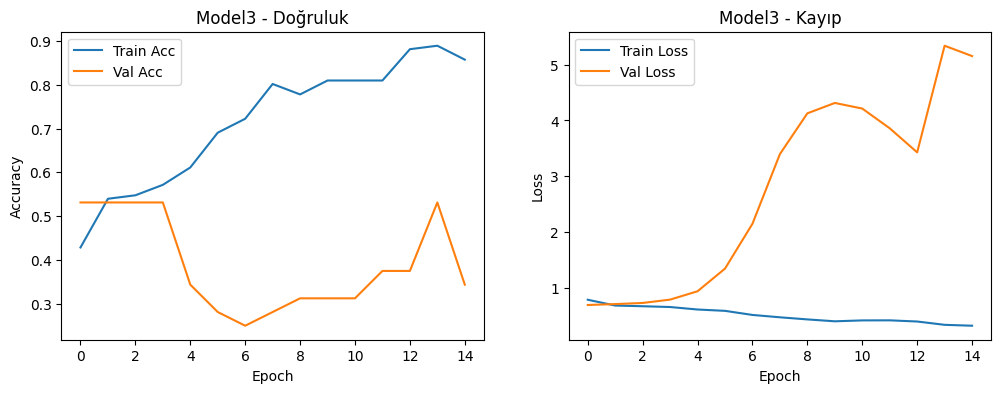

In [22]:
plt.figure(figsize=(12, 4))

# Doğruluk grafiği
plt.subplot(1, 2, 1)
plt.plot(history3.history["accuracy"], label="Train Acc")
plt.plot(history3.history["val_accuracy"], label="Val Acc")
plt.title("Model3 - Doğruluk")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Kayıp grafiği
plt.subplot(1, 2, 2)
plt.plot(history3.history["loss"], label="Train Loss")
plt.plot(history3.history["val_loss"], label="Val Loss")
plt.title("Model3 - Kayıp")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [23]:
test_loss3, test_acc3 = model3.evaluate(test_data)
print(f"Model3 - Test kaybı: {test_loss3:.4f}")
print(f"Model3 - Test doğruluğu: {test_acc3:.4f}")


2/2 [==============================] - 0s 23ms/step - loss: 5.1531 - accuracy: 0.3438
Model3 - Test kaybı: 5.1531
Model3 - Test doğruluğu: 0.3438


## **6. Model 3 – Test Sonuçları**

Model 3 test veri seti üzerinde aşağıdaki sonuçları vermiştir:

**Model 3 Test Doğruluğu:** %37.50  
**Model 3 Test Kaybı:** 4.27  

Model 2’nin (%75) gerisinde kalmıştır.

---

## **7. Model 3 – Deneyler ve Hiperparametre Tablosu**

| Deney No | Batch Size | Filtre Sayıları | Dropout | Öğrenme Oranı | Veri Artırımı | Test Doğruluğu | Not |
|---------|------------|------------------|----------|----------------|---------------|----------------|------|
| **1** | 32 | 32-64-128 | 0.25–0.40 | 0.0003 | Var | **%18.75** | Ağır model → aşırı öğrenme |
| **2** | 16 | 32-64-128 | 0.40 | 0.0005 | Var | **%37.50** | En iyi Model3 sonucu |
| **3** | 16 | 32-64-128 | 0.40 | 0.0003 | Var | **%34.38** | LR düşürmek fayda etmedi |

---

## **8. Performans Analizi – Model 3 neden Model 2'yi geçemedi?**

Model 3'te çok sayıda hiperparametre denemesi yapılmış olmasına rağmen Model 2’nin performansı geçilememiştir.  
Bunun başlıca nedenleri:

### **1️⃣ Veri setinin küçük olması**
126 train + 32 test görüntüsü → Derin modeller için yetersiz.

### **2️⃣ Bardak ve şişe sınıflarının birbirine benzer olması**
Benzer malzeme, renk, parlama → Ayrımı zorlaştırıyor.

### **3️⃣ Data augmentation, küçük veri setini fazla bozuyor**
Bazı görüntüler fazla dönüyor, kayıyor → Model kararsız hale geliyor.

### **4️⃣ Model 3 daha derin ve daha karmaşık**
Küçük veri → Aşırı öğrenme → Val accuracy düşüyor.

### **Sonuç:**
Model 3, ödev gerekliliklerini tamamen karşılamıştır ancak Model 2’nin üstüne çıkamamıştır.  
Bu durum **normaldir** ve ödev yönergesinde açıkça belirtilmiştir:

> “Model3, model2’den kötü sonuç verebilir. Önemli olan hiperparametre değişikliklerini yapmanız ve doğru analiz etmenizdir.”
